## Spread of classifier scores
### Authors: D. Tolosa, P. Joshi, R. Banda, B. Ziemann

This is a simple notebook that produces a plot for visualization of the spread of the classifier scores (in probability) for the 243 subjects. 

**_This project was developed at The Data Mine, Purdue University, in partnership with Molecular Stethoscope._**

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
### Reding csv file containing 243 subjects and their raw TPM counts across 1059 genes
### Source of data
myDF = pd.read_excel("/anvil/projects/tdm/corporate/molecular-stethoscope/data-s23/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name = 1)
# setting index row name to the gene id
myDF = myDF.set_index('gene_id')

### Step 1: Data prep

In [23]:
#Filtering out rows: discarding the ERCC rows, ERCC is a control protocol for validation of RNA sequencing
Patients_df = myDF[~myDF.loc[:,'Coeff'].isnull()]

# We store the coefficients(betas) of the linear classifier in an array.
coefficients = np.nan_to_num(np.array(Patients_df.loc[:, "Coeff"]))

# Filtering out columns with patient data
Patients_df = Patients_df.filter(regex='^\d+')

In [24]:
# group columns by patient id
grouped_cols = Patients_df.columns.str.split('-').str[0]

# group columns by patient id and r1/r2 suffixes
grouped = Patients_df.groupby(grouped_cols, axis=1)

# apply the mean function to the r1 and r2 columns for each group
# taking mean of the replicates for subjects with multiple replicates
Patients_df = grouped.apply(lambda x: x.mean(axis=1)).reset_index(drop=True)
# Patients_df.head()

### Step 2: Computing Zscores from TPM data

In [25]:
Patients_df['Mean']= Patients_df.mean(axis=1)
Patients_df['Std']=Patients_df.iloc[:,:-1].std(axis=1)
#Patients_df.head()

In [26]:
# We define a function whose input is TPM and outputs the corresponding Zscore
def z_score(x):
    return (x-x['Mean'])/x['Std']

In [27]:
# Computing and storing zscores
Patients_df_zScore = Patients_df.apply(lambda x: z_score(x), axis=1)
# Patients_df_zScore.head()

### Step 3: Defining classifier functions

In [28]:
# This score is the classifer linear score, before converting to probability, i.e. sum (beta * zScores)
def linear_score(coefficients, col):
    linear_score = np.sum(coefficients * col, axis=0)
    return linear_score

# Function to perform anti-logit operation on the linear score 
def cl_score(linear_score, gamma = 0):
    temp = gamma + linear_score
    classifier_score = np.exp(temp) / (1 + np.exp(temp))
    return classifier_score

### Step 4: Plotting classifier scores

([], [])

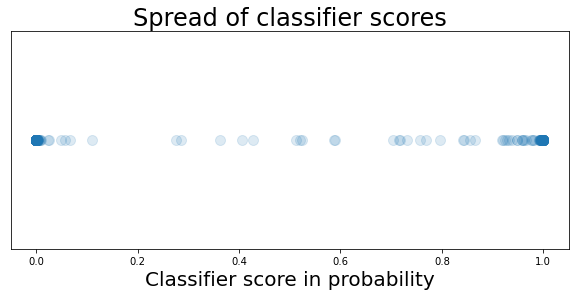

In [30]:
y = np.zeros(243)
x = np.ones(243)
for i in range(243):
        y[i] = cl_score(linear_score(coefficients, Patients_df_zScore.iloc[:, i]))
fig = plt.figure(figsize=(10,4))
plt.scatter(y,x,cmap = 'Dark2_r' ,alpha = 0.15, s=100)
plt.title('Spread of classifier scores', fontsize = 24)
plt.xlabel("Classifier score in probability", fontsize= 20)
plt.yticks([])
#plt.savefig('figures/class_scores.png')